## Loading and preprocessing the datasets
In this section we are loading and preprocessing the datasets. Please note that some of the data we used are proprietary of US Bank and so we're not being able to make those datasets publicly available. In case you'd like to access those datasets please reach out to any of us. Our email ids can be found in the repository README.md file.

In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Loading the datasets
#HPI = pd.read_csv("USSTHPI.csv") # Quarterly HPI data
HPI_PO = pd.read_csv("data/HPI_Purchase_only_yoy_change.csv") # HPI Purchase Only data
EHS = pd.read_excel("data/Existing Home Sales.xlsx") # Existing Home Sales data, proprietary of US Bank.
StockQt = pd.read_excel("data/HousingStockWorksheet.xlsx", sheet_name = "Stock_Quarterly") # Housing Stock data, proprietary of US Bank.

In [3]:
# Chaging the column name and cleaning the HPI data
HPI_PO.DATE = pd.to_datetime(HPI_PO.DATE)
new_name = {'HPIPONM226S_PC1' : "YoY"}
HPI_PO.rename(columns=new_name, inplace= True)
HPI_PO.drop(HPI_PO.tail(1).index, inplace= True)
HPI_PO.YoY = HPI_PO.YoY.astype(float)

In [4]:
# Cleaning the quarterly housing stock data
StockQt.rename(columns={"Unnamed: 15" : "col 15", "Unnamed: 16" : "Eff_HS_US"}, inplace=True)
StockQt.drop(columns=["col 15"], inplace= True)
StockQt.dropna(subset=["Eff_HS_US"],inplace = True)
Quarters = StockQt.Quarter.values
Quarter_to_Date = {"Q1" : "-01-01",
                  "Q2" : "-04-01",
                  "Q3" : "-07-01",
                  "Q4" : "-10-01"}
Dates = []
for i in Quarters:
    y = i.split()[0]
    y+= Quarter_to_Date[i.split()[1]]
    Dates.append(y)
StockQt.Quarter = Dates


In [5]:
# Cleaning the existing home sells data
EHS.EOM = pd.to_datetime(EHS.EOM)
EHS.rename(columns= {"EOM" : "DATE"}, inplace = True)
EHS.dropna(subset=["Existing Home Sales"], inplace=True)
EHS["DATE"] = EHS.DATE.dt.to_period('Q')
EHS_Q = pd.DataFrame(EHS.groupby("DATE").mean())
EHS_Q.reset_index(inplace= True)
EHS_Q.drop(EHS_Q.tail(1).index,inplace=True)
EHS_Q["House_Stock"] = StockQt.Eff_HS_US.values
EHS_Q["Implied_Turnover"] = (EHS_Q["Existing Home Sales"]/(EHS_Q.House_Stock/1000))*100

In [6]:
# Calculating implied turnover and adding it as a column
Turnover = list(EHS_Q.Implied_Turnover.values)
Turnover = [np.nan]*(HPI_PO.shape[0]-len(Turnover))+Turnover
HPI_PO["Implied_Turnover"] = Turnover

In [7]:
# Loading and preprocessing the housing credit availability index (HCAI) dataset
HCAI = pd.read_excel("data/HCAI.xlsx", sheet_name="Whole Market")
HCAI
new_header = HCAI.loc[2]
HCAI = HCAI[3:]
HCAI.columns = new_header
HCAI = HCAI[HCAI.columns[:6]]
HCAI.rename(columns={"Year" : "DATE"}, inplace=True)
HCAI.DATE = HCAI.DATE.apply(lambda x: str(x).split()[0])
DATE = HCAI.DATE.values
Quarter = HCAI.Quarter.values
new_dates = []
for i in range(len(DATE)):
    if Quarter[i] == 1:
        new_dates.append(DATE[i]+"-01-01")
    elif Quarter[i] == 2:
        new_dates.append(DATE[i]+"-04-01")
    elif Quarter[i] == 3:
        new_dates.append(DATE[i]+"-07-01")
    elif Quarter[i] == 4:
        new_dates.append(DATE[i]+"-10-01")
    else:
        raise ValueError("Invalid value for quarter")
HCAI.DATE = new_dates
HCAI.DATE = pd.to_datetime(HCAI.DATE)
HCAI.columns = [x.replace("\n", '') for x in HCAI.columns.to_list()]
HCAI = HCAI.iloc[4:,[0,3]]
df = pd.merge(HPI_PO, HCAI, on='DATE', how='outer')
#df.dropna(subset=["Implied_Turnover"], inplace = True)
df.fillna(method='ffill',inplace= True)

## Visualising _implied turnover_ with predictors

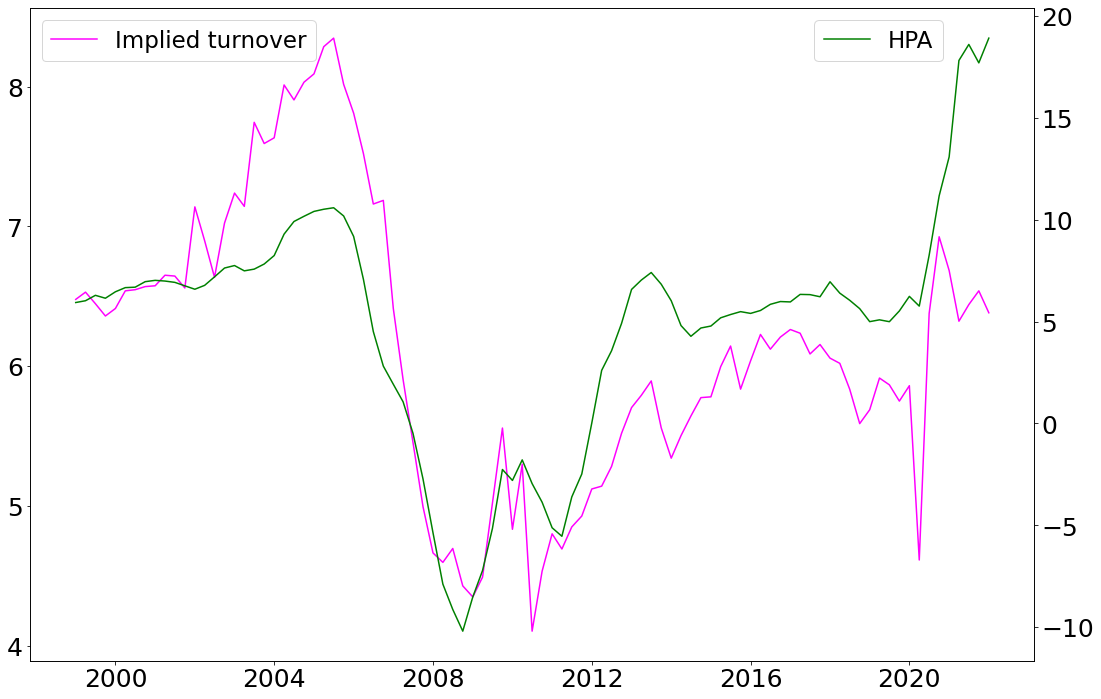

In [8]:
# visualising HPA with implied turnover
df_HPA = df.dropna(subset = ["Implied_Turnover"])
fig,ax1 = plt.subplots()
fig.set_figheight(12)
fig.set_figwidth(18)
ax1.plot(df_HPA.DATE, df_HPA.Implied_Turnover, linewidth=1.5,label='Implied turnover', color = 'magenta')
ax2 = ax1.twinx()
ax2.plot(df_HPA.DATE, df_HPA.YoY, linewidth=1.5,color='green',label='HPA')
ax1.legend(loc='upper left', fontsize=23)
ax2.legend(loc='upper right', bbox_to_anchor=(0.42, 0.5, 0.5, 0.5), fontsize=23)
ax1.tick_params(axis='both', which='major', labelsize=25)
ax2.tick_params(axis='both', which='major', labelsize=25)
#fig.suptitle("HPA and Implied Turnover", size = 20)
plt.show()
fig.savefig("HPIvsIT.png")

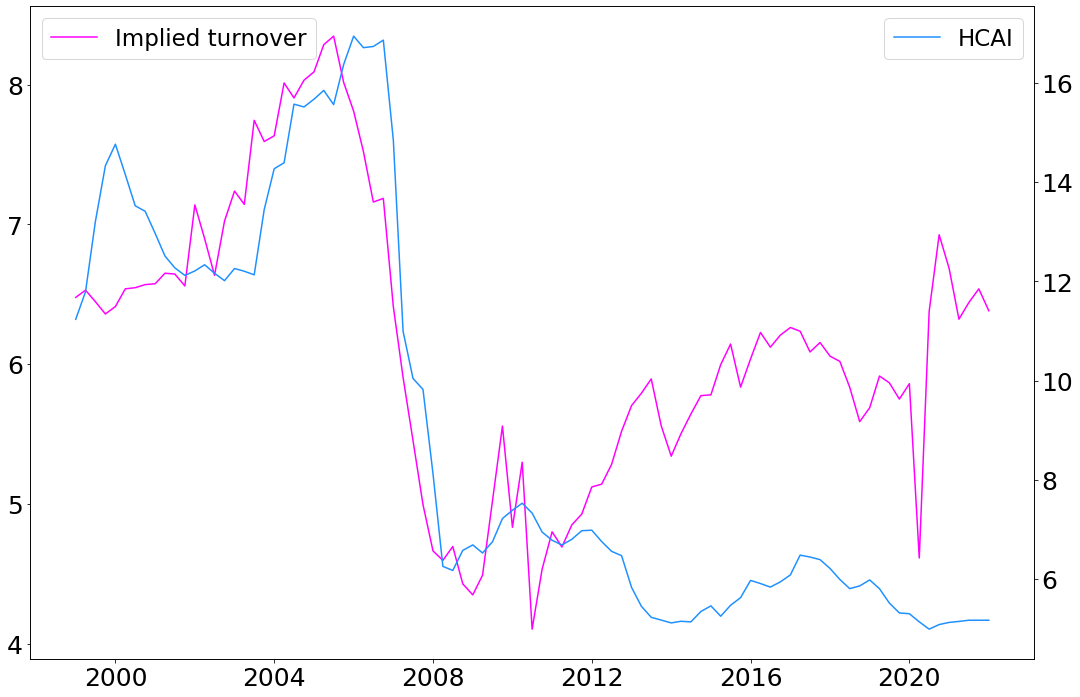

In [9]:
# visualising HCAI with implied turnover
from datetime import datetime
import matplotlib.dates as mdates
fig,ax1 = plt.subplots()
fig.set_figheight(12)
fig.set_figwidth(18)
ax1.plot(df.DATE, df.Implied_Turnover, linewidth=1.5,label='Implied turnover', color = 'magenta', markersize=22)
ax2 = ax1.twinx()
ax2.plot(df.DATE,df.TotalRisk, linewidth=1.5,color='dodgerblue',label='HCAI')
ax1.legend(loc='upper left', fontsize=23)
ax2.legend(loc='upper right', fontsize=23)
#fig.suptitle("HCAI and Implied Turnover", size = 20)
ax1.tick_params(axis='both', which='major', labelsize=25)
ax2.tick_params(axis='both', which='major', labelsize=25)
plt.show()
fig.savefig("HCAIvsIT.png")

## Selecting most effective predictors

In this section we are performing some feature engineering and coming up with new features from the existing features. E.g. we are creating moving average of HPA and HCAI with different window sizes. Then we are training linear model with each predictor to find out which one works the best for our purposes.

We looked at the R-squared of each of the models and decided to go forward with the following two predictors:

* 6-quarter moving average of HPA
* HCAI

In [10]:
import statsmodels.api as sm
YoY_windows = 12
TR_windows = 12
lags = 6

ModelDescription ={}
for i in range(1,YoY_windows):
    s="YoY_MA_Window%i"%i
    df[s] = df.YoY.rolling(i).mean()
    data = df.dropna(subset=["Implied_Turnover"])
    model_name = "model_"+s
    ModelDescription[model_name] = {"Features" : s}
    lm =sm.OLS.from_formula("Implied_Turnover ~ %s"%s, data = data).fit()
    ModelDescription[model_name]["model"] = lm
    
for j in range(1, TR_windows):
    s = "TR_MA_Window%i"%j
    df[s] = df.TotalRisk.rolling(j).mean()
    data = df.dropna(subset=["Implied_Turnover", s])
    model_name = "model_"+s
    ModelDescription[model_name] = {"Features" : s}
    lm =sm.OLS.from_formula("Implied_Turnover ~ %s"%s, data = data).fit()
    ModelDescription[model_name]["model"] = lm

for lag in range(1,lags):
    s = "YoY_Lag%i"%lag
    df[s] = df.YoY.shift(lag)
    data = df.dropna(subset=["Implied_Turnover", s])
    model_name = "model_"+s
    ModelDescription[model_name] = {"Features" : s}
    lm = sm.OLS.from_formula("Implied_Turnover ~ %s"%s, data= data).fit()
    ModelDescription[model_name]["model"] = lm
for lag in range(1,lags):
    s = "TR_Lag%i"%lag
    df[s] = df.TotalRisk.shift(lag)
    data = df.dropna(subset=["Implied_Turnover", s])
    model_name = "model_"+s
    ModelDescription[model_name] = {"Features" : s}
    lm = sm.OLS.from_formula("Implied_Turnover ~ %s"%s, data= data).fit()
    ModelDescription[model_name]["model"] = lm

In [11]:
for i in (ModelDescription.values()):
    print(i["Features"], )
    print('R_squared = ',i["model"].rsquared,'\n\n')

YoY_MA_Window1
R_squared =  0.525476372907772 


YoY_MA_Window2
R_squared =  0.5429542948729017 


YoY_MA_Window3
R_squared =  0.5595540470478273 


YoY_MA_Window4
R_squared =  0.574113051242837 


YoY_MA_Window5
R_squared =  0.5875685330163019 


YoY_MA_Window6
R_squared =  0.5967890004441652 


YoY_MA_Window7
R_squared =  0.6004509257356379 


YoY_MA_Window8
R_squared =  0.6001470541875815 


YoY_MA_Window9
R_squared =  0.595656649248811 


YoY_MA_Window10
R_squared =  0.5884931910186406 


YoY_MA_Window11
R_squared =  0.5793009756928469 


TR_MA_Window1
R_squared =  0.5022529310514938 


TR_MA_Window2
R_squared =  0.477244062645132 


TR_MA_Window3
R_squared =  0.4504007422555968 


TR_MA_Window4
R_squared =  0.42084640365366943 


TR_MA_Window5
R_squared =  0.38956648330365495 


TR_MA_Window6
R_squared =  0.3571370440801769 


TR_MA_Window7
R_squared =  0.32463176257480175 


TR_MA_Window8
R_squared =  0.29382227844998543 


TR_MA_Window9
R_squared =  0.26435325983703606 


TR_MA_

In [13]:
# building the model with best predictors
data = df.dropna(subset= ["Implied_Turnover", "TotalRisk"])
lm = sm.OLS.from_formula("Implied_Turnover ~ TotalRisk+ YoY_MA_Window6", data = data.iloc[:-10,:]).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:       Implied_Turnover   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     235.0
Date:                Thu, 04 Aug 2022   Prob (F-statistic):           3.24e-34
Time:                        22:13:16   Log-Likelihood:                -40.619
No. Observations:                  83   AIC:                             87.24
Df Residuals:                      80   BIC:                             94.49
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          4.4747      0.117     38.

## Future work

We have a few different ways to try and improve upon this model.

* As we saw above, HPA with a lag of 2-quarters also seem to work very well. We can try moving average with some lag. We can also try weighted moving average and try out different weights for that matter.

* We can try to train a more sophisticated architecture like LSTM than just simple linear regression.

* We can try to incorporate other predictors like _Mobility_ in our model.